In [2]:
import numpy as np
import seaborn as sns
from scipy import signal 
from matplotlib import pyplot as plt

In [3]:
sns.set(rc={'figure.figsize': (11, 8)})
np.random.seed(100)

In [4]:
# %% preprocessing

def g(x):
    return np.tanh(x)

def g_prime(x):
    return 1 - g(x) * g(x)

def center(x):
    x = np.array(x)
    mean = x.mean(axis=1, keepdims=True)
    return x - mean

def whitening(x):
    cov = np.cov(x)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    x_transformed = np.dot(E,np.dot(D_inv, np.dot(E.T, x)))
    return x_transformed

def calculate_new_w(w, x):
    # Decorrelate weights
    w_new = (x * g(np.dot(w.T, x))).mean(axis=1) - g_prime(np.dot(w.T, x)). mean() * w
    w_new /= np.sqrt((w_new ** 2).sum()) #Euclidean norm
    return w_new

def preprocessing(x):
    x = center(x)
    x = whitening(x)
    return x

In [5]:
#fast ICA
def ICA(x, itr, tolerance=1e-5): 
    x = preprocessing(x)
    
    n = x.shape[0]
    W = np.zeros((n, n), dtype=x.dtype)
    
    for i in range(n):
        w = np.random.rand(n)
        for j in range(itr):
            w_new = calculate_new_w(w, x)
            if(i >= 1):
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            if(distance < tolerance):
                break
        W[i, :] = w
    s = np.dot(W, x)
    return s


In [6]:
def plot_mixture_sources_predictions(x, original_sources, s):
    fig = plt.figure()
    
    plt.subplot(3, 1, 1)
    for i in x:
        plt.plot(i)
    plt.title("mixtures")
    
    plt.subplot(3, 1, 2)
    for j in original_sources:
        plt.plot(j)
    plt.title("real sources")
    
    plt.subplot(3, 1, 3)
    for z in s:
        plt.plot(z)
    #plt.plot(s) wrong
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [7]:
n_samples = 5000
time = np.linspace(0, 10, n_samples)
s1 = np.sin(2 * time)  
s2 = np.sign(np.sin(3 * time))  
s3 = signal.sawtooth(2 * np.pi * time) 


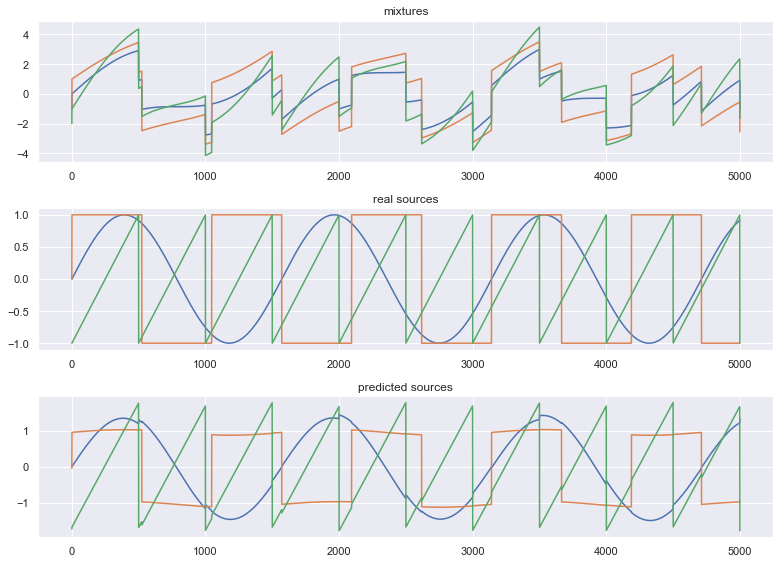

In [8]:
# Source matrix
S = np.c_[s1, s2, s3]
# Mixing matrix
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
# Mixed signal matrix
X = np.dot(S, A.T)
X = X.T
S = ICA(X, itr=1000)
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

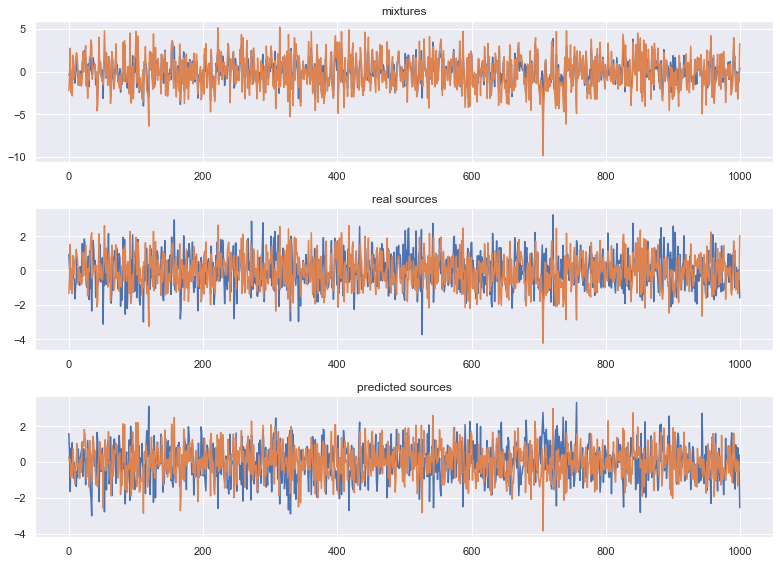

In [9]:
# Define two gaussian components
s1n = np.random.normal(size=1000)
s2n = np.random.normal(size=1000)
# Source matrix
S = np.c_[s1n, s2n]
# Mixing matrix
A = np.array(([[1, 1], [0.5, 2]]))
# Mixed signal matrix
X = np.dot(S, A.T)
X = X.T
S = ICA(X, itr=1000)
plot_mixture_sources_predictions(X, [s1n, s2n], S)

In [10]:
# Define two non-gaussian uniform components
s1 = np.random.rand(1000)
s2 = np.random.rand(1000)

sn = np.array(([s1n, s2n]))
s = np.array(([s1, s2]))

# Define orthogonal mixing matrix
A = np.array(([0.96, -0.28],[0.28, 0.96]))

# Mix signals
mixedSignals = s.T.dot(A)
mixedSignalsN = sn.T.dot(A)


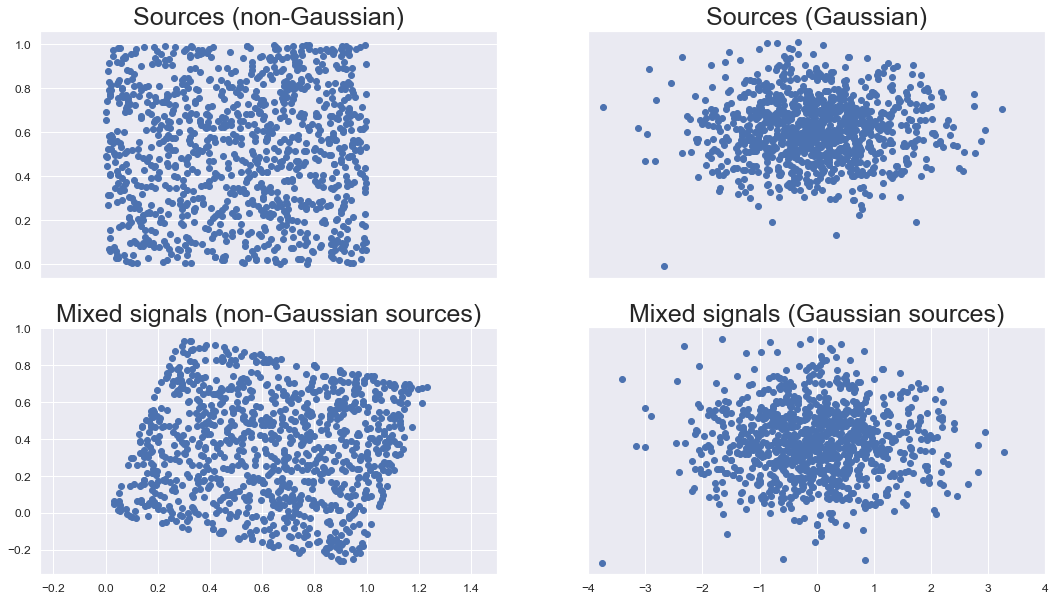

In [11]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=[18, 10])
ax[0][0].scatter(s[0], s[1])
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_title('Sources (non-Gaussian)', fontsize=25)
ax[0][0].set_xlim([-0.25, 1.5])
ax[0][0].set_xticks([])

ax[0][1].scatter(sn[0], sn[1])
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_title('Sources (Gaussian)', fontsize=25)
ax[0][1].set_xlim([-4, 4])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(mixedSignals.T[0], mixedSignals.T[1])
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_title('Mixed signals (non-Gaussian sources)', fontsize=25)
ax[1][0].set_xlim([-0.25, 1.5])

ax[1][1].scatter(mixedSignalsN.T[0], mixedSignalsN.T[1])
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_title('Mixed signals (Gaussian sources)', fontsize=25)
ax[1][1].set_xlim([-4, 4])
ax[1][1].set_yticks([])

plt.show()